Index(['frequency', 'length', 'n_avg_hypernyms', 'n_avg_hyponyms',
       'n_avg_synonyms', 'n_consonantconjuncts', 'n_consonants', 'n_hypernyms',
       'n_hyponyms', 'n_syllables', 'n_synonyms', 'n_synsets', 'n_vowels',
       'label'],
      dtype='object')
[(0, 6260), (1, 1488)]
[(0, 1488), (1, 1488)]
0     0.127769
1     0.050690
2     0.086586
3     0.114143
4     0.077578
5     0.044267
6     0.050457
7     0.074138
8     0.088959
9     0.060484
10    0.107988
11    0.067683
12    0.049258
dtype: float64


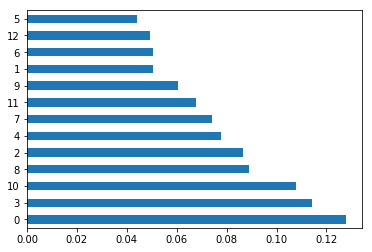

Weight,Feature
0.3081 ± 0.0140,n_avg_hyponyms
0.2249 ± 0.0154,n_synonyms
0.2053 ± 0.0084,n_avg_hypernyms
0.1880 ± 0.0112,n_synsets
0.1788 ± 0.0054,frequency
0.1577 ± 0.0110,n_hyponyms
0.1407 ± 0.0054,n_hypernyms
0.0982 ± 0.0081,n_syllables
0.0931 ± 0.0103,n_avg_synonyms
0.0876 ± 0.0056,n_consonants


In [5]:
import os
import time
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import eli5
from eli5.sklearn import PermutationImportance
#from xgboost import plot_importance
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display

#from data_tests import *
from models import get_model
from evaluation import get_accuracy

def ensemble_learning(X, y, baseline = -1, model_num = None, resample = 0, feature_set = None, n_features = 0, feature_importance = 0, average_method='macro', path= None):
    """
    Store the results calculated according to the arguments and store them in a file.
    Arguments:
    X (dataframe): examples
    y (dataframe): target/label
    baseline (int): -1 for no baseline, 1 for all predictions as 1, 0 for all predictions as 0
    model_num (int): classification model
    1: 
    2:
    3:
    4:
    5:
    6:
    resample (int): -1 for undersampling, 1 for oversampling and 0 for no resampling
    feature_set (list): list of features to be considered
    n_features (int): the number of features to be considered at a time for classification/importance
    feature_importance (int): 0 for absent, 1 for present
    average_method: macro by default
    path: the path to the directory where the recordings should be stored
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
   
    #prepare the dictionary to be written to the file
    data_dict = dict()
    dir_name = path + str(time.time())
    os.mkdir(dir_name)
    
    #open the config file for writing
    config_file = open(dir_name + '/config.json', 'w')

    data_dict =  {'model_num':model_num}
    data_dict =  {'baseline':baseline}
    data_dict.update({'resample':resample})
    data_dict.update({'feature_set':feature_set})
    data_dict.update({'n_features':n_features})
    data_dict.update({'feature_importance':feature_importance})
    
    #create test set labels for the baseline if applicable
    if baseline == 0:
        y_test = y_test.replace(1,0)
    elif baseline == 1:
        y_test = y_test.replace(0,1)
            
    #resample the training set (if applicable)
    if resample == -1:
        #undersample
        '''NearMiss 3 . NearMiss-3 is a 2-step algorithm: first, for each minority sample, 
        their :m nearest-neighbors will be kept; then, the majority samples selected are the 
        on for which the average distance to the k nearest neighbors is the largest.'''
        nm = NearMiss(version=3)
        print(sorted(Counter(y_train).items()))
        X_resampled, y_resampled = nm.fit_resample(X_train, y_train)
        X_train = X_resampled
        y_train = y_resampled
        print(str(sorted(Counter(y_train).items())))
    elif resample == 1:
        #oversample
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
        X_train = X_resampled
        y_train = y_resampled
        print(sorted(Counter(y_resampled).items()))
    #write the training dataset class distribution to the file
    file = open(dir_name + '/train_val_dist.csv', 'a')
    file.write(str(sorted(Counter(y_train).items())))
    file.write('\n')
    file.close()

    model = get_model(model_num)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
        
    #TODO: evaluation
    accuracy = get_accuracy(y_test, y_pred)
    data_dict['accuracy'] = accuracy * 100
    score = model.score(X_test,y_test)
    data_dict['score'] = score

    if feature_importance == 1:
        feat_importances = pd.Series(model.feature_importances_, index=feature_set)
        print(feat_importances)
        feat_importances.nlargest(20).plot(kind='barh')
        #plot_importance(model)
        plt.show()

        perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
        display(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))
        

        #write the training dataset class distribution to the file
        file = open(dir_name + '/feature_importances.csv', 'a')
        file.write(feat_importances.to_string())
        file.write('\n')
        file.close()

        #write the permutation importance values to the file
        file = open(dir_name + '/permutation_feature_importances.csv', 'a')
        file.write(str(perm))
        file.write('\n')
        file.close()

    json.dump(data_dict, config_file)
    config_file.close()

data = pd.read_csv('/opt/PhD/Work/JHWNL_1_2/Data/CleanedData/Basic Binary Classification/DataForClassification.csv')
#print(data.iloc[:, 1:-1].head())
del data['word']
print(data.columns)
ensemble_learning(data.iloc[:, :-1], data.label, baseline = -1, model_num = 1, feature_importance=1, resample = -1, path = '/opt/PhD/Work/JHWNL_1_2/Data/Analysis/')
#TODO: evaluation
#TODO: permutation importance for each model
#TODO: learning curve
#TODO: run this in a notebook